In [550]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display
from sklearn.model_selection import train_test_split
import keras.backend as K

tf.compat.v1.enable_eager_execution()

In [551]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(3*2*128, use_bias=False, input_shape=(50,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((3, 2, 128)))
    #assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
   
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 28, 28, 1)

    return model

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 768)               38400     
_________________________________________________________________
batch_normalization_73 (Batc (None, 768)               3072      
_________________________________________________________________
leaky_re_lu_124 (LeakyReLU)  (None, 768)               0         
_________________________________________________________________
reshape_25 (Reshape)         (None, 3, 2, 128)         0         
_________________________________________________________________
conv2d_transpose_73 (Conv2DT (None, 3, 2, 128)         409600    
_________________________________________________________________
batch_normalization_74 (Batc (None, 3, 2, 128)         512       
_________________________________________________________________
leaky_re_lu_125 (LeakyReLU)  (None, 3, 2, 128)       

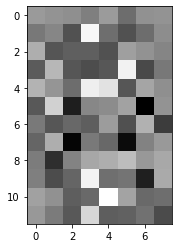

In [532]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 50])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [533]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[12, 8, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [534]:
discriminator = make_discriminator_model()
discriminator.summary()
#decision = discriminator(generated_image)
#print (decision)

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 6, 4, 64)          640       
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 6, 4, 64)          0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 6, 4, 64)          0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 3, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_128 (LeakyReLU)  (None, 3, 2, 128)         0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 3, 2, 128)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 768)             

In [535]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [536]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [537]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [538]:
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

In [539]:
EPOCHS = 100
noise_dim = 50
num_examples_to_generate = 3
gen_loss_li=[]
disc_loss_li=[]

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [540]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #print("gen_loss = "+str(gen_loss.eval())+" disc_loss = "+str(disc_loss.eval))
        #gen_loss_li.append(gen_loss)
        #disc_loss_li.append(disc_loss)
        tf.print(gen_loss, disc_loss)
        #print(type(gen_loss), type(disc_loss))
        #print(K.eval(gen_loss))
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [541]:
new_shape=[12,8]

def reshape(input_array):
    shape = np.shape(input_array)
    padded_array = np.zeros((shape[0], new_shape[0], new_shape[1], 1))
    padded_array[:,:shape[1],:shape[2],:] = input_array.reshape((shape[0], shape[1], shape[2], 1))
    return padded_array

def min_max_normalization(new_X_array):
    new_x= np.zeros(new_X_array.shape)

    for i in range(new_X_array.shape[2]):
        
        min_val = new_X_array[0][0][i]
        max_val= new_X_array[0][0][i]
        for array in new_X_array:
            for item in array:
                if item[i] < min_val:
                    min_val = item[i]
                if item[i] > max_val:
                    max_val = item[i]

        for j, array in enumerate(new_X_array):
            for k, item in enumerate(array):
                new_x[j][k][i] = (item[i] - min_val) / (max_val - min_val)
                #x_test[j][k][i] = item[i]
    
    return new_x
    

In [542]:
X_array = np.load('ip_sequences_new_10.npy')
Y_array = np.load('y_array_new_10.npy')
X_array=np.delete(X_array,[6], axis=2)
X_array=np.delete(X_array,[3], axis=2)

new_x = min_max_normalization(X_array)

#generate 1 percent data 
reduced_x_train, reduced_x_valid, reduced_y_train, reduced_y_valid = train_test_split(new_x, Y_array, test_size=0.1, shuffle= True,stratify=Y_array)

'''
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(reduced_x_valid, reduced_y_valid, test_size=0.33, shuffle= True, stratify=reduced_y_valid)
'''

'\n# Split the data\nx_train, x_valid, y_train, y_valid = train_test_split(reduced_x_valid, reduced_y_valid, test_size=0.33, shuffle= True, stratify=reduced_y_valid)\n'

In [543]:
x_train_reshaped = reshape(reduced_x_valid)
x_train_reshaped.shape

(2393, 12, 8, 1)

In [544]:
print(np.count_nonzero(reduced_y_valid == 1)/reduced_y_valid.shape[0], np.count_nonzero(reduced_y_valid == 0)/reduced_y_valid.shape[0])
print(np.count_nonzero(reduced_y_valid == 1))

0.05348934391976599 0.946510656080234
128


In [545]:
x_train_bots= np.array([], np.float32)

for cur_index,array in enumerate(x_train_reshaped):
    if reduced_y_valid[cur_index][0] == 1:
        x_train_bots = np.append(x_train_bots, np.asarray(array, dtype='float32'))
        
x_train_bots_ = x_train_bots.reshape(np.count_nonzero(reduced_y_valid == 1),new_shape[0],new_shape[1] ,1)


In [546]:
x_train_bots_.shape

(128, 12, 8, 1)

In [547]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        num_batches=int(dataset.shape[0]/BATCH_SIZE)
        for i in range(0,num_batches):
            #print ("Epoch "+ str(epoch)+ " batch "+ str(i))
            train_batch= dataset[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE,:, :, :]
            train_step(train_batch)
        
        # Produce images for the GIF as we go
        if epoch % 10 == 0 and epoch >= 500:
            generate_and_save_numpys(generator,epoch + 1,seed)
        

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    '''
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    '''

In [548]:
def generate_and_save_numpys(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    if epoch % 1 ==0:
        for cur_index,generated_volume in enumerate(predictions):
            #return_img_fin = nib.Nifti1Image(generated_volume.numpy(), np.eye(4))
            filename='Security_research/bots_numpys/dcgan_bots_'+str(epoch)+'_'+str(cur_index)
            
            np.save(filename, generated_volume)

In [549]:
BATCH_SIZE=32
train(x_train_bots_, 1500)

0.702928305 1.35888898
0.727549434 1.27539527
0.748787224 1.2436111
0.756613255 1.19567966
Time for epoch 1 is 0.8277180194854736 sec
0.743529797 1.15697718
0.740301788 1.10538149
0.723404944 1.15166032
0.699616909 1.14541066
Time for epoch 2 is 0.023847341537475586 sec
0.685057163 1.12078953
0.677203655 1.0873642
0.670244455 1.17110598
0.690457463 1.15869904
Time for epoch 3 is 0.023212194442749023 sec
0.686278224 1.1273973
0.697317719 1.11953425
0.718023658 1.17902124
0.71795094 1.21001363
Time for epoch 4 is 0.023203134536743164 sec
0.770693958 1.17547882
0.785453498 1.17353475
0.810441554 1.25756669
0.84835273 1.26734674
Time for epoch 5 is 0.02325892448425293 sec
0.914371192 1.24739408
0.920859456 1.24912536
0.974131 1.24245584
0.969266891 1.26025593
Time for epoch 6 is 0.023453235626220703 sec
0.986788869 1.19968224
1.00568676 1.1580292
0.985517502 1.14212656
0.95326072 1.13876665
Time for epoch 7 is 0.023379087448120117 sec
0.967951298 1.10229242
0.88424027 1.11570573
0.90131044

In [454]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


NameError: name 'history' is not defined